In [1]:
import ccd
import numpy as np

In [2]:
import datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb

In [3]:
import logging

# Configure logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)


In [15]:
dc = datacube.Datacube(app="Landsat_Surface_Reflectance")
ds = load_ard(dc=dc,
              products=["ls8_sr", "ls9_sr"],
              measurements=['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'pixel_quality'],
              output_crs='EPSG:6933',
              y=(-34.3155, -34.316),
              x=(18.4455, 18.446),
              time=("2018-01", "2022-01"),
              resolution=(-30, 30),
              group_by="solar_day",
              min_gooddata=0.9,
             )

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
    ls9_sr
Counting good quality pixels for each time step


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 45 out of 88 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 45 time steps


In [16]:
ds_thermal = load_ard(dc=dc,
              products=["ls8_st", "ls9_st"],
              measurements=['surface_temperature'],
              like = ds,
             ).sel(time=ds.time)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_st
    ls9_st
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 86 time steps


In [17]:
ds['st'] = ds_thermal.surface_temperature
ds_mean = ds.isel(x=0, y=0)

In [18]:
ds_mean

<xarray.Dataset>
Dimensions:        (time: 45)
Coordinates:
  * time           (time) datetime64[ns] 2018-02-15T08:35:25.780158 ... 2022-...
    y              float64 -4.127e+06
    x              float64 1.78e+06
    spatial_ref    int32 6933
Data variables:
    blue           (time) float32 0.04593 0.04651 0.04758 ... 0.05226 0.05072
    green          (time) float32 0.05957 0.06109 0.06109 ... 0.06573 0.06436
    red            (time) float32 0.06513 0.06546 0.06375 ... 0.07181 0.07063
    nir            (time) float32 0.1625 0.1662 0.1667 ... 0.1805 0.1767 0.1752
    swir_1         (time) float32 0.2409 0.2417 0.2403 ... 0.2606 0.2567 0.2596
    swir_2         (time) float32 0.151 0.1554 0.1509 ... 0.1651 0.1612 0.164
    pixel_quality  (time) uint16 21824 21824 21824 21824 ... 21824 21824 21824
    st             (time) float32 304.1 301.9 303.2 296.6 ... 302.9 309.1 310.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [48]:
params = {'QA_BITPACKED': False,
    'QA_FILL': 1,
    'QA_CLEAR': 0,
    'QA_WATER': 7,
    'QA_SHADOW': 4,
    'QA_SNOW': 5,
    'QA_CLOUD': 3,
    'QA_CIRRUS1': 2,
    'QA_CIRRUS2': 2,
    'QA_OCCLUSION': 4}

In [56]:
# Configure logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

dates = (ds_mean.time.values - np.datetime64(0,'D'))/np.timedelta64(86400000000000, 'ns')
quality = np.zeros(len(ds_mean.time.values)).astype(int)
blues, greens, reds, nirs, swir1s, swir2s = ds_mean.blue.values, ds_mean.green.values, ds_mean.red.values, ds_mean.nir.values, ds_mean.swir_1.values, ds_mean.swir_2.values
blues, greens, reds, nirs, swir1s, swir2s = blues*10000, greens*10000, reds*10000, nirs*10000, swir1s*10000, swir2s*10000
results = ccd.detect(dates, blues, greens, reds, nirs, swir1s, swir2s, ds_mean.st.values, quality, params=params)

Result: 0
Start Date: 2018-02-15 00:00:00
End Date: 2021-10-05 00:00:00
Break Date: 2021-10-05 00:00:00
QA: 8
Norm: 267.02647853228996

Change prob: 0.0


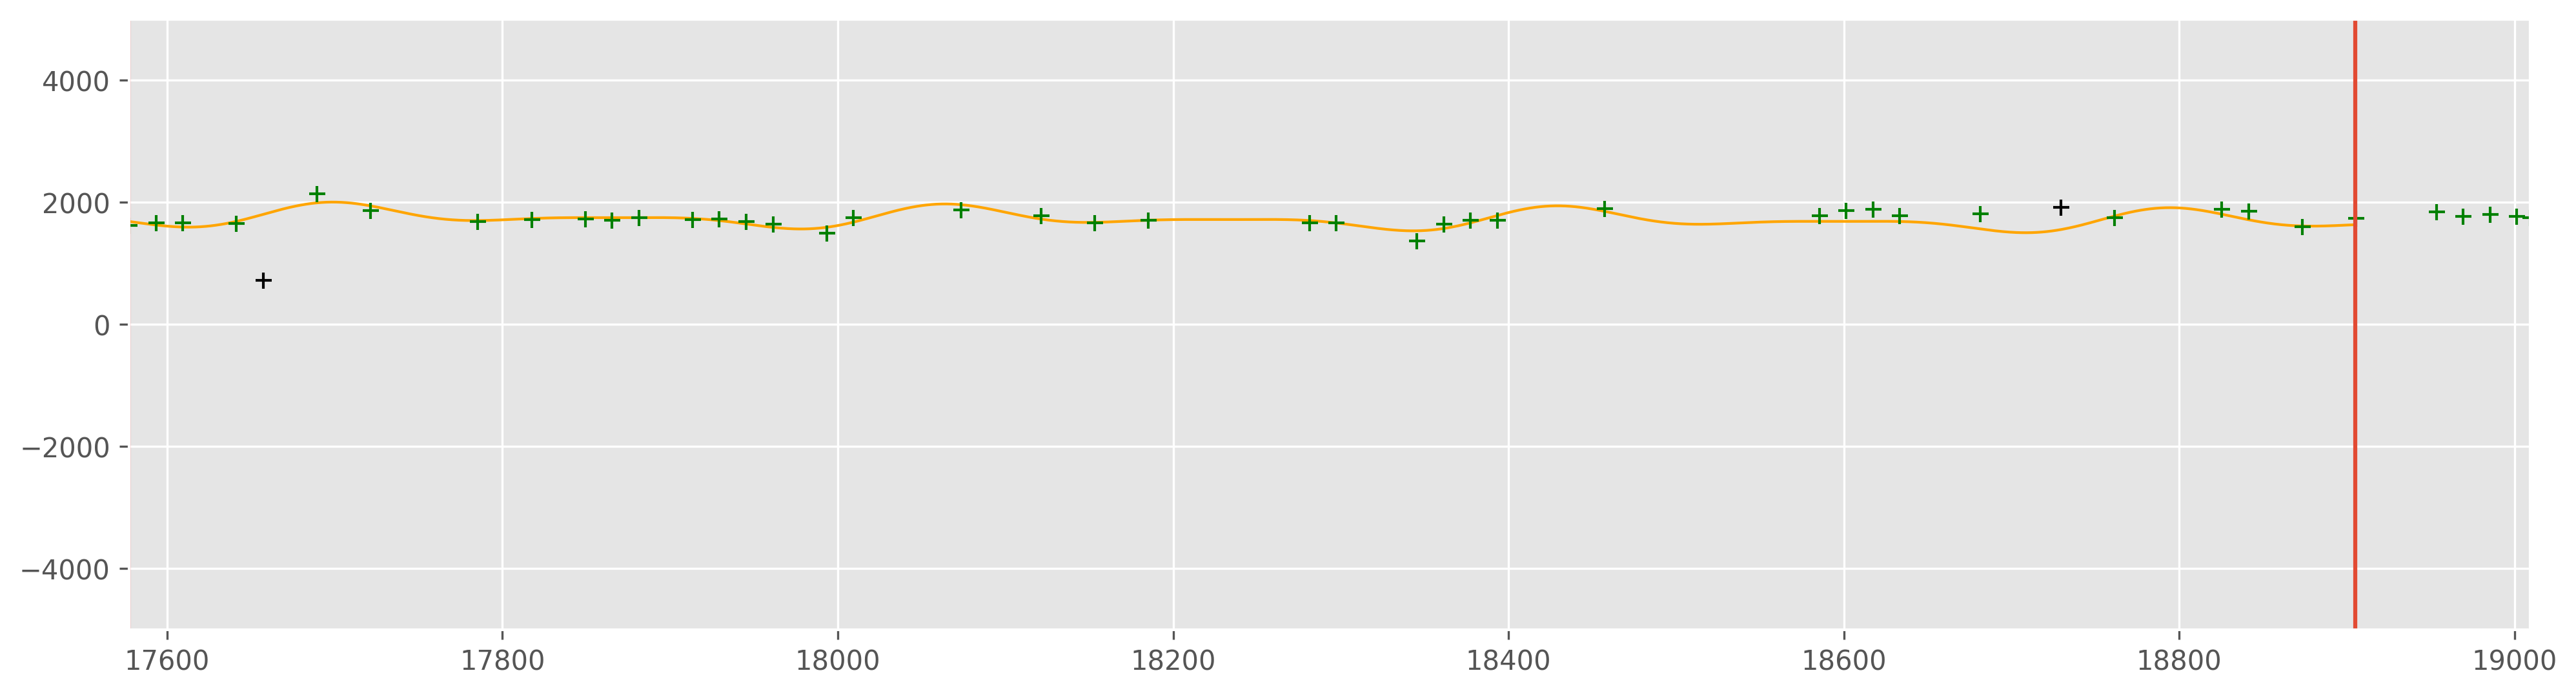

In [58]:
from datetime import datetime
from matplotlib import pyplot as plt

band = 'nir'
mask = np.array(results['processing_mask'], dtype=bool)

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []

ordinal = datetime(year=1970, month=1, day=1).toordinal()

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(datetime.fromordinal(result['start_day']+ordinal)))
    print('End Date: {}'.format(datetime.fromordinal(result['end_day']+ordinal)))
    print('Break Date: {}'.format(datetime.fromordinal(result['break_day']+ordinal)))
    print('QA: {}'.format(result['curve_qa']))
    print('Norm: {}\n'.format(np.linalg.norm([result['green']['magnitude'],
                                            result['red']['magnitude'],
                                            result['nir']['magnitude'],
                                            result['swir1']['magnitude'],
                                            result['swir2']['magnitude']])))
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    prediction_dates.append(days)
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    
    intercept = result[band]['intercept']
    coef = result[band]['coefficients']
    
    predicted_values.append(intercept + coef[0] * days +
                            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
                            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
                            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))
    
plt.style.use('ggplot')

fg = plt.figure(figsize=(16,9), dpi=300)
a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)), ylim=(-5000, 5000))

# Predicted curves
for _preddate, _predvalue in zip(prediction_dates, predicted_values):
    a1.plot(_preddate, _predvalue, 'orange', linewidth=1)

a1.plot(dates[mask], eval(f'{band}s[mask]'), 'g+') # Observed values
a1.plot(dates[~mask], eval(f'{band}s[~mask]'), 'k+') # Observed values masked out
for b in break_dates: a1.axvline(b)
for s in start_dates: a1.axvline(s, color='r')